In [4]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
pip install tensorflow_datasets


  Using cached tensorflow_datasets-4.9.2-py3-none-any.whl (5.4 MB)
     ---------------------------------------- 77.1/77.1 kB 1.1 MB/s eta 0:00:00
  Using cached etils-1.2.0-py3-none-any.whl (120 kB)
  Using cached promise-2.3.tar.gz (19 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 101.3/101.3 kB 6.1 MB/s eta 0:00:00
  Using cached tensorflow_metadata-1.13.1-py3-none-any.whl (28 kB)
     ---------------------------------------- 3.0/3.0 MB 8.7 MB/s eta 0:00:00
  Using cached importlib_resources-5.12.0-py3-none-any.whl (36 kB)
     ------------------------------------- 223.6/223.6 kB 14.2 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21547 sha256=16e73952e767adde779f76161877533793c94b413f91a8cbed8db6235607f0a0
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\54\4e\28\3ed0e1c8a752867445bab994d2340724928aa3ab059c57c8db
Succes


[notice] A new release of pip available: 22.2.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
print(tf.__version__)

2.12.0


In [6]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


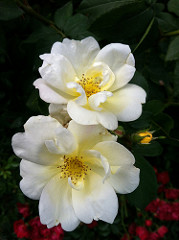

In [8]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

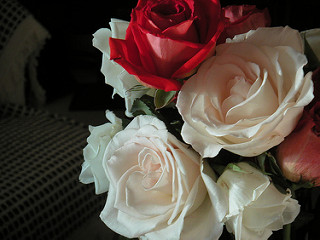

In [9]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [10]:
batch_size = 32
img_height = 180
img_width = 180

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


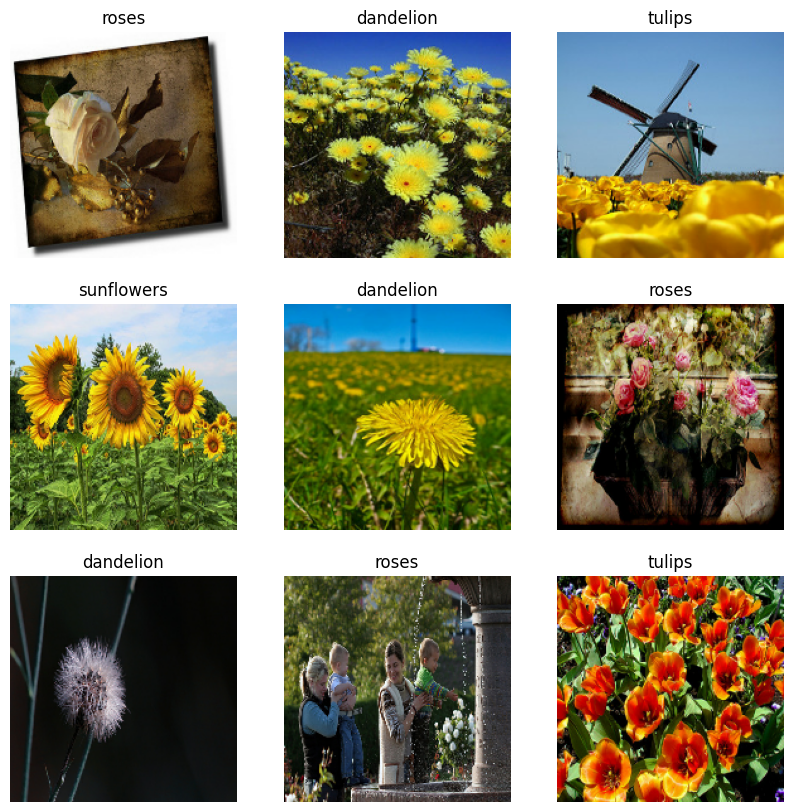

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [20]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [21]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 97s 1s/step - loss: 1.3699 - accuracy: 0.4169 - val_loss: 1.1752 - val_accuracy: 0.5123
Epoch 2/3
92/92 [==============================] - 84s 910ms/step - loss: 1.0656 - accuracy: 0.5756 - val_loss: 1.0191 - val_accuracy: 0.5995
Epoch 3/3
92/92 [==============================] - 81s 878ms/step - loss: 0.9382 - accuracy: 0.6328 - val_loss: 0.9602 - val_accuracy: 0.6213


In [22]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [23]:
for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\Dell\\.keras\\datasets\\flower_photos\\tulips\\3502974120_9f1eceaf8b_n.jpg'
b'C:\\Users\\Dell\\.keras\\datasets\\flower_photos\\daisy\\2635314490_e12d3b0f36_m.jpg'
b'C:\\Users\\Dell\\.keras\\datasets\\flower_photos\\roses\\1392579828_ab5a139052.jpg'
b'C:\\Users\\Dell\\.keras\\datasets\\flower_photos\\daisy\\2346726545_2ebce2b2a6.jpg'
b'C:\\Users\\Dell\\.keras\\datasets\\flower_photos\\roses\\4764674741_82b8f93359_n.jpg'


In [24]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [25]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [26]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [27]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [28]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [29]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [30]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [31]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  4


In [32]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

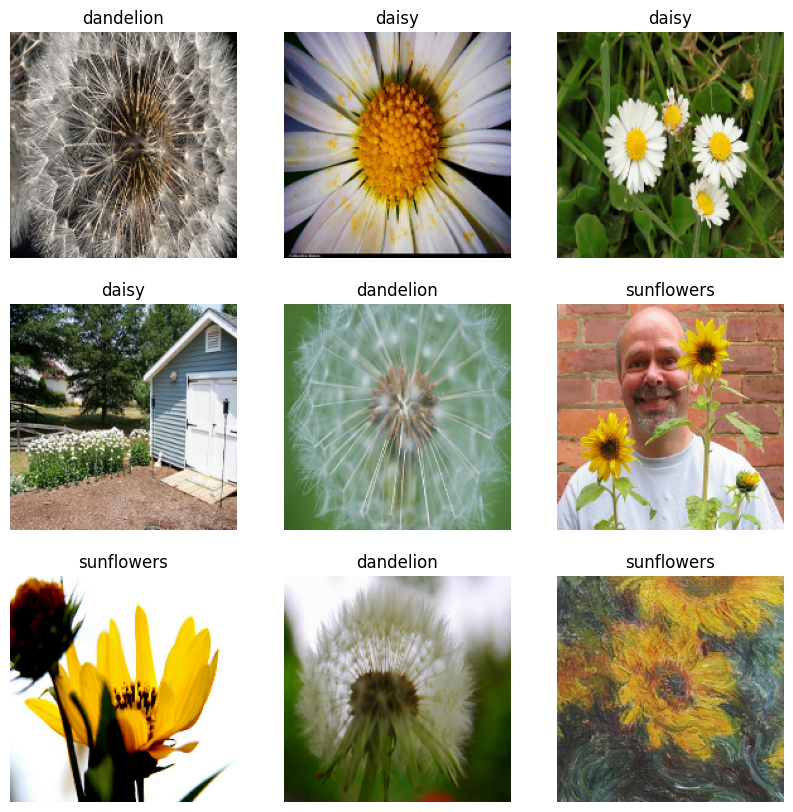

In [33]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [34]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 90s 937ms/step - loss: 0.7885 - accuracy: 0.7054 - val_loss: 0.8247 - val_accuracy: 0.6730
Epoch 2/3
92/92 [==============================] - 85s 923ms/step - loss: 0.6121 - accuracy: 0.7783 - val_loss: 0.7942 - val_accuracy: 0.7153
Epoch 3/3
92/92 [==============================] - 87s 944ms/step - loss: 0.4539 - accuracy: 0.8420 - val_loss: 0.8999 - val_accuracy: 0.6894


In [35]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Dell\tensorflow_datasets\tf_flowers\3.0.1.incomplete8WHBLJ\tf_flowers-train.tfrecord*...:  …

Dataset tf_flowers downloaded and prepared to C:\Users\Dell\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [36]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


In [ ]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [ ]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)